# Setups/ Imports

# Establishing Baseline Models- WEEKLY DATA

#### Background
The overall goal of this entire project is to create 3000 different weekly forecast for each individual SKU/product. However, in this notebook I will go on a short tangent to check some very important concepts. The purpose of this notebook is to use the previously coded 10 broad categories to test if these items are able to be predicted based on their historical data. We would hope to see no random walks, and all 10 categories showing improvements in the prediction errors with more complicated models(another indicator that the data is not a random walk)

#### Plan of Attack

>1. First I will check each each broad category (10 categories) for signal, and make sure these time series are not random walks or white noise data points. White noise is random data points, and random walks are intervals of time that cannot be correlated to their pasts, and therefore make them unpredictable using only historic data. We will use the adfuller test to accomplish this.
>2. Next, I will establish two basic forecasts (Naive Forecast, Moving Average) to use as a baseline 
>3. Finally, I will compare the baseline averages with some slightly more complicated models (Simple Exponential Smoothing, Holts Linear Trend, Holts Winter Model)

#### Metrics
1. MAE(Mean Absolute Error)
>MAE very simply, takes the average of all the absolute values of your prediction errors. The smaller the number the better, with a 0 MAE meaning there was an average of 0 errors in your prediction!
>MAE will help us measure the difference between a baseline model and the arima model. 
>I chose MAE over MSE because I want to get a general sense of the errors as they are. I'm not so concerned with penalizing higher error with the MSE metric.
2. Alpha = .05
>For all of the hypothesis testing, I will resort to the industry standard and set the significance level= .05


#### About-Models

>Naive Forecast
>* A Naive forecast is simply taking the previous periods value. This works suprisingly well for random walk time series, and is the most basic/primitive model you can use.

>Moving Average
>* This will serve as a great baseline measure for the ARIMA model
>* a moving average simply makes you name a time period (say 7 days), take the average of the values in that time period, and use that predict tomorrow's value. It is up to you to choose a relevant time period.

>Simple Exponential Smoothing
>* Gives higher weights to recent data, and lower weights to older data and then takes the average of the values with the weights taken into account.

>Holts Linear Trend
>* Holts Linear Trend will do the same as the exponential smoothing, but also take into account the trend of the data

>Holts Winter Model
>* Holts Winter Method does triple exponential smoothing to try to uncover seasonality and trend.
You must calculate the correct seasonality



In [0]:
#Colab stuffs:

#get a fast operator system
!nvidia-smi

#mount google drive
from google.colab import drive
drive.mount('/content/drive')#click on the link it provides and copy and paste that code into the authorization area

#access the OS system to work with current directories:
import os 

Sat Oct  5 20:33:30 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%pip install hurst

In [0]:
#imports
import warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from sklearn import metrics
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.despine()
sns.set(rc={'figure.figsize':(15,9)})
%matplotlib inline

In [0]:
#Import the cleaned up data frame from the "clean up report"
#Turn the CSV files into data frames
dfrev = pd.read_csv('drive/My Drive/Capstone_2/data/wkly_rev_pivot.csv', index_col= 'invdate', low_memory=False)
dfqty = pd.read_csv('drive/My Drive/Capstone_2/data/wkly_qty_pivot.csv', index_col= 'invdate', low_memory=False)

#Adding total columns
dfqty ["total"]= dfqty.sum(axis = 1, skipna = True)
dfrev ["total"]= dfrev.sum(axis = 1, skipna = True)

#resetting index to datetime
dfqty.index = pd.to_datetime(dfqty.index)
dfrev.index = pd.to_datetime(dfrev.index)

# Steps:

1. Decomposition of the timeseries (trends, seasonality, and noise)
2. Checking for white noise
3. Checking for random walks
4. Splitting into test/train splits
5. Naive forecast
6. Simple Moving Average
7. More complicated models


***
# 1. Decomposition (Seasonality, Trend, Noise)

#### What is it?

Basically it's an handy way to look at the abstract of timeseries data. It uses stastistical methods to break down the time series into three components:

* seasonality:
>* does the data display a clear periodic pattern?

* trend:
>* does the data follow a consistent upwards or downward slope?

* noise:
>* are there any outlier points or missing values that are not consistent with the rest of the data?


***The BLUE line represents the total amount of grocery items***


<Figure size 432x288 with 0 Axes>

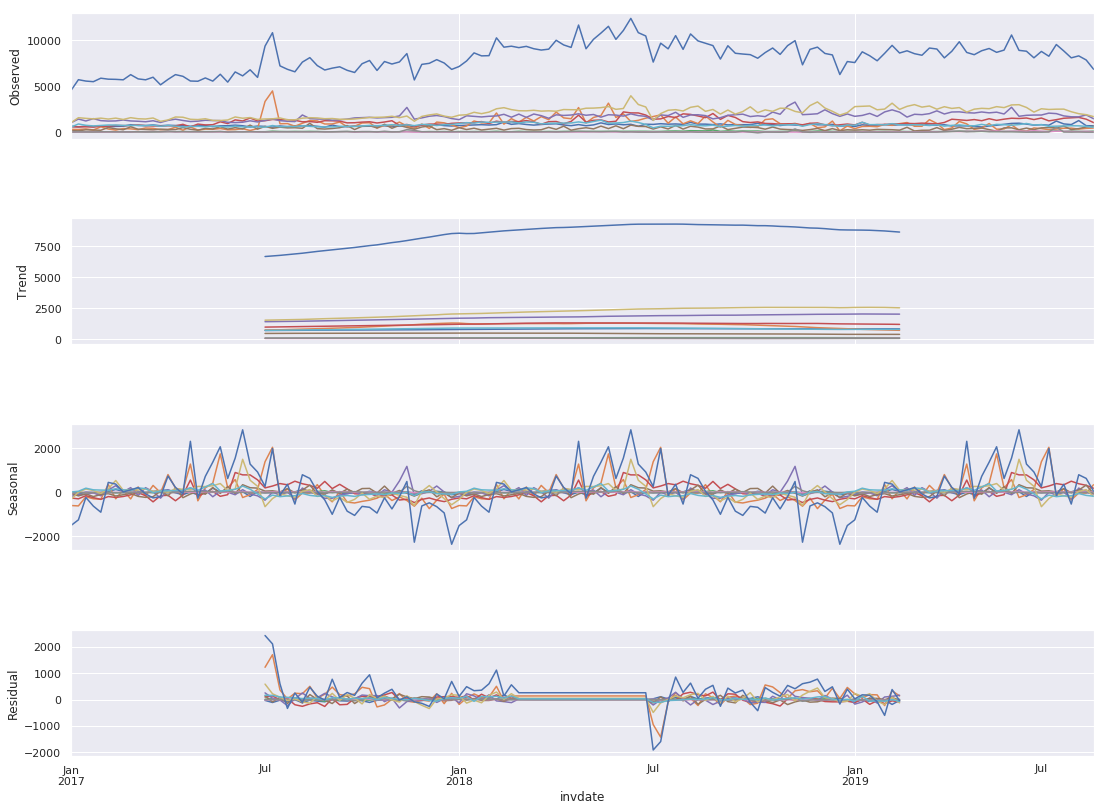

In [0]:
#fig, ax1 = plt.subplots(figsize=(20, 10))

from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(dfqty, freq=52)

fig = plt.figure()  
fig = decomp.plot()  
fig.set_size_inches(18, 14)

In [0]:
dfqty.head()

,dairy,delivery,dry_goods,fruit,herb,juice,oil,specialty,veg,"veg,root",total
invdate,,,,,,,,,,,
2017-01-02,672.0,329.0,53.0,598.09,1036.50,184.0,26.00,35.25,1039.34,563.00,4536.18
2017-01-09,586.0,307.0,39.0,595.94,1444.60,166.0,27.66,50.50,1589.91,908.75,5715.36
2017-01-16,678.0,374.0,31.0,597.78,1233.59,280.0,40.00,47.00,1519.00,765.58,5565.95
2017-01-23,629.0,257.0,45.0,573.06,1490.00,244.0,58.00,42.00,1465.68,697.05,5500.79
2017-01-30,704.0,597.0,38.5,660.37,1271.79,229.0,33.00,60.00,1542.74,741.80,5878.20


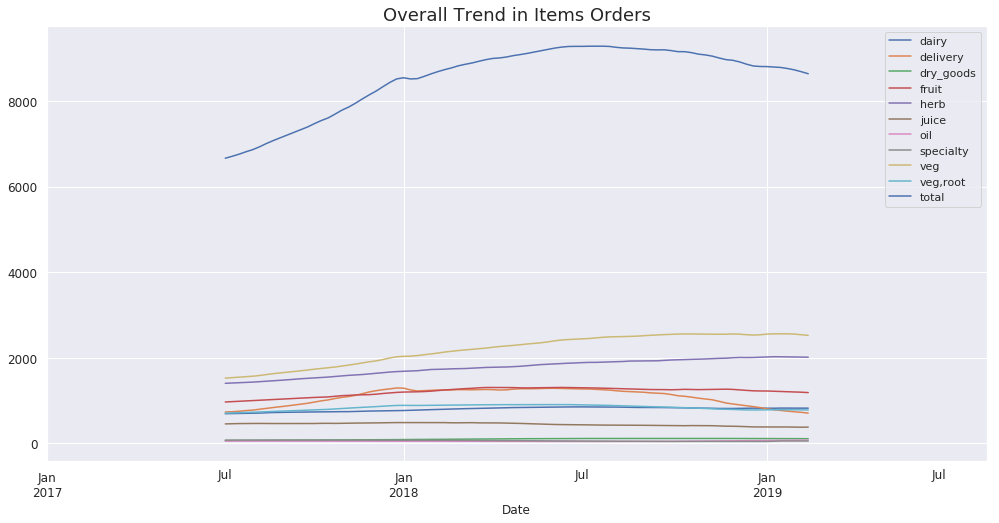

In [0]:
#A CLOSER LOOK AT TREND

# Perform time series decompositon
decomposition = sm.tsa.seasonal_decompose(dfqty, freq=52)

# Extract the trend component
trend = decomposition.trend

# Plot the values of the trend
ax = trend.plot(figsize=(15, 8), fontsize=12)

# Specify axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Overall Trend in Items Orders', fontsize=18)
plt.show()

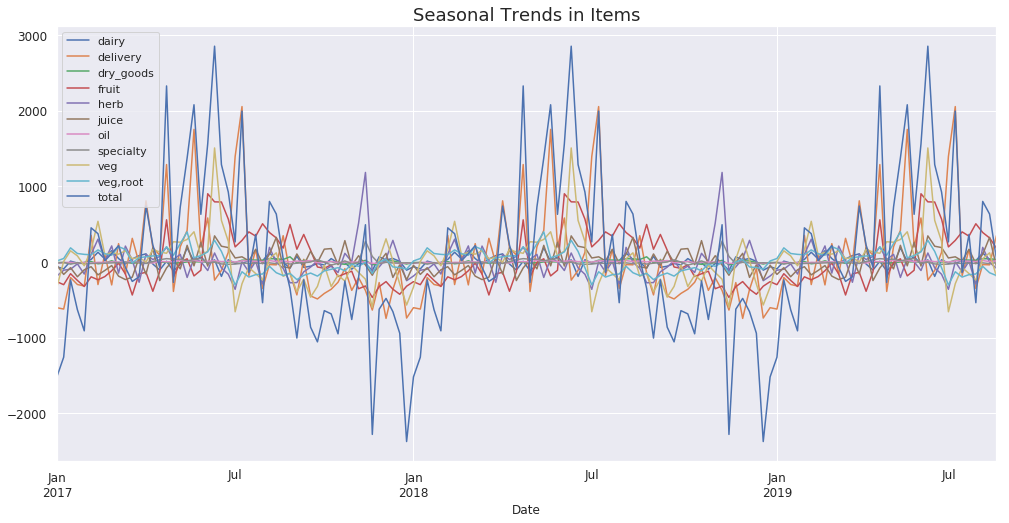

In [0]:
# A CLOSER LOOK AT SEASONALITY
seasonality = decomposition.seasonal

ax = seasonality.plot(figsize=(15, 8), fontsize=12)

# Specify axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Seasonal Trends in Items', fontsize=18)
plt.show()

#### Insights


* Trend:
> Initially, from the smaller general graph, the trend seems to have increased till 2018 with a slight decline in 2019. However, upon closer inspection we can see that the "delivery category" is the only category that has a signficant downward trend. The delivery category only represents things like bottle/crate returns, and Boulder's sugar tax. Thus, this downward trend is not so significant, and it's more of a leveling out.
* Seasonality:
>* There is clear seasonality in the data where there's an increase in purchases in the Summer months and decreases of purchases in the winter months
>* Upon closer inspection the fruit, vegetable, and delivery category seems to be the main drivers of this seasonality. Again, delivery seems to be playing a crucial role in this time series data.
* Noise
> The residuals are interesting, showing periods of high variability in the month of July. This also correlates to some order spikes surrounding the July Months.
* Delivery Category
>* The delivery cateogory is a highly influencial category as far as trend, noise, and seasonality go, and it perhaps should not be included since it is not a product itself.
>* The delivery cateogory is composed of bottle and crate deposits, the Boulder's Sugar tax, "opened" deliveries, samples, and storage. All of these cateogories could be analyzed on their own because clearly something is happening in recently in this category, but this section does not need to be a part of the predictive model in which items to order and when.



# 2. Checking for White Noise 

#### What is it?

* White noise means all the entries are identically distributed with a mean of zero independent of each other
>* Basically, this means that the entries are random entries, and for timeseries forcasting we need to be able to detect patterns in the data

* Two Times to Check for White Noise:

>1. You first check for white noise in the beginning to make sure you can create a forecasting model
>2. You check after you make a prediction using your model, and make sure the residuals of your prediction ARE producing white noise. 
>>* If the errors of your model are white noise this is good because it means your model used all possible signal or trends in the data to produce it's prediction. If your model diagnostics do not produce white noise, then it means there's more you can do to improve your model.

> *In the **beginning** you do not want your data to be white noise. At the **end** you want your model to produce random residuals (white noise).*


#### Why it matters

1. This makes it impossible to make a forecasting model if there's white noise in the beginning
2. This means you can work to improve your model if you find white noise in the end

#### Characteristics of a White Noise

*   mean = close to zero
*   standard deviation = close to 1
*   constant variance

#### Difference between White Noise and a Random Walk

A random walk differs from white noise because it is talking about the steps (or chunks of time) being random & independent, but not the points themselves. Also, the variance increases linearly with each step (not constant). 

To put it simply, think the of S & P: white noise is like the daily changes of the points of the S & P, while a random walk is the S&P daily level itself.

In [0]:
dfqty.describe()

,dairy,delivery,dry_goods,fruit,herb,juice,oil,specialty,veg,"veg,root",total
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,781.495942,901.443261,91.027971,1150.861812,1728.075145,426.188333,57.312246,61.713261,2122.470072,797.120797,8117.708841
std,121.121276,648.770733,33.491665,356.343893,385.767530,166.514327,28.517966,63.148680,567.919201,162.301880,1578.538882
min,558.000000,136.000000,31.000000,573.060000,1036.500000,117.000000,24.000000,-53.000000,1039.340000,489.020000,4536.180000
25%,703.062500,427.500000,70.000000,895.242500,1440.475000,297.752500,40.000000,29.000000,1571.602500,674.705000,6842.322500
50%,782.000000,757.000000,89.500000,1116.895000,1744.700000,400.125000,49.125000,55.500000,2198.210000,760.980000,8346.190000
75%,843.125000,1125.000000,106.150000,1363.160000,1959.660000,523.500000,62.750000,71.375000,2566.145000,858.892500,9139.460000
max,1278.200000,4495.000000,251.800000,2218.380000,3284.700000,979.000000,173.000000,562.000000,3970.500000,1331.000000,12371.430000


#### Insights:
* Based on our ACL/ PACL graphs, and the mean, variance, and STD stastics below, we can safely say our data is **NOT** white noise, and we can use timeseries forecasting to predict the inventory.


# 3. Checking for Random Walks
#### What is it?
* Random Walks typically happen in financial data a lot. It basically means the data is taking successive steps that are random (think a literal "random walk"). The steps are successive, but not predictable. Within each period the variable takes a random step away from its previous value, and the steps are independently and identically distributed in size (“i.i.d.”). 
* This concept was popularized in 1973 with the publishing of "A Random Walk Down Wallstreet" [book link](https://https://en.wikipedia.org/wiki/A_Random_Walk_Down_Wall_Street)
* The best prediction for a random walk is to look at the previous "step" or timeframe and use that to predict the future value. This is called a "Naive" or baseline forecast.
* If we dont have a random walk process, we will not be able to predict future changes.

#### Why it matters?
* It is important that we will not be diving into creating complicated models for random walk processes because they won't be able to beat the naive model.

#### How to check?
1. We will be using the Augmented Dickey-Fuller hypothesis test. With this test, the null hypothesis is that the time series IS a non-stationary series. Thus, we want all the p-values to be below .05 which means we have a 5% or less chance to see a value this extreme or greater, and we can reject the null hypothesis that they are non-stationary

2. Check the Hurst Exponent

3. Check correlogram plots of original data.

4. Check correlogram plots for the converted stationary data.

5. Does the Naive model outperform more complicated models? We will measure this in sections 6, 7, & 8.


## 3.1 Checking for Stationarity

In [0]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

for col in dfqty.columns:
   results = adfuller(dfqty[col])
   print (f"{col} p-value= {str(results[1])}")

dairy p-value= 0.24181077332283046
delivery p-value= 0.026291596342551814
dry_goods p-value= 0.1996634742893756
fruit p-value= 0.06687427572658126
herb p-value= 0.32465231536727857
juice p-value= 0.062234862949459215
oil p-value= 0.1693424313233476
specialty p-value= 1.7973497009815923e-17
veg p-value= 0.5319212027053395
veg,root p-value= 0.0836878287179712
total p-value= 0.19161129453827663


In [0]:
results = adfuller(fruitdiff)
print (f"Fruit p-value= {str(results[1])}")

Fruit p-value= 0.0007455810418064386


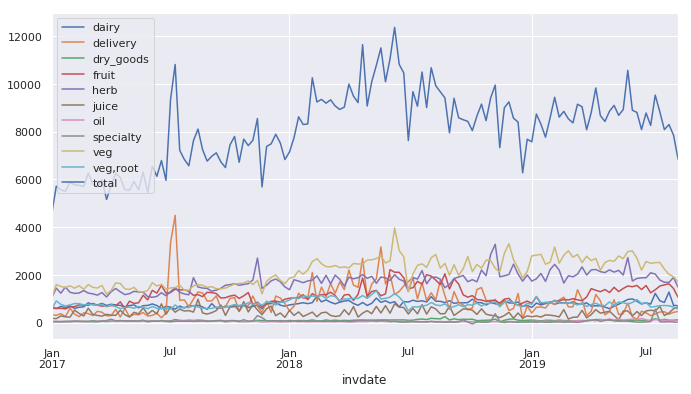

In [0]:
dfqty.plot(figsize = (10, 6))

#### Insights:
* ALL categories are non-stationary EXCEPT the specialty and delivery category. The fruit and juice categories are on the cusp of being stationary
* This is not-suprising because we would expect to see seasonality and trend in grocery products. However this is a sign we have a random walk process.



## 3.2 Hurst Exponent
* The Hurst Exponenent is another way to measure if a time series is a random walk. 
* If the Hurst exponent is > .5 it is trending
* < .5 and its anti-persistent time series
* Close to .5 and its a random walk

In [0]:
from hurst import compute_Hc, random_walk

for col in dfqty.columns:
  H, c, data = compute_Hc(dfqty[col], kind='change', simplified=True)
  print (f'{col} Hurst Exp: {H}')

dairy Hurst Exp: 0.8312079055088167
delivery Hurst Exp: 0.7244266424614864
dry_goods Hurst Exp: 0.6831993014220291
fruit Hurst Exp: 0.6097868892176037
herb Hurst Exp: 0.7046978003245572
juice Hurst Exp: 0.927638385283214
oil Hurst Exp: 0.7326367613986695
specialty Hurst Exp: 0.6131721336050926
veg Hurst Exp: 0.5856909213490473
veg,root Hurst Exp: 0.6595874315189961
total Hurst Exp: 0.6351421522394134


#### Insights
* Vegetable is the category most closely resembling a random walk

## 3.3 Correlgram Plots
Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band. See the Wikipedia entry for more about autocorrelation plots.

Text(0.5, 1.0, 'Correlogram of the Different Categories')

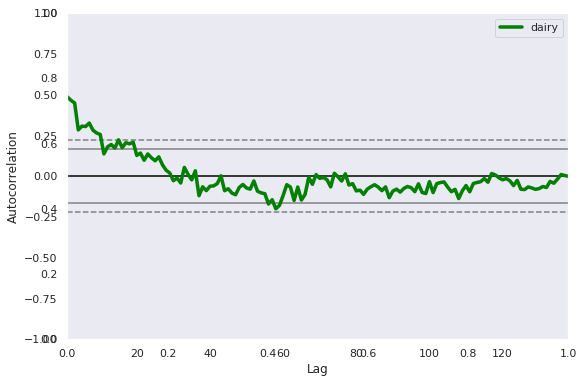

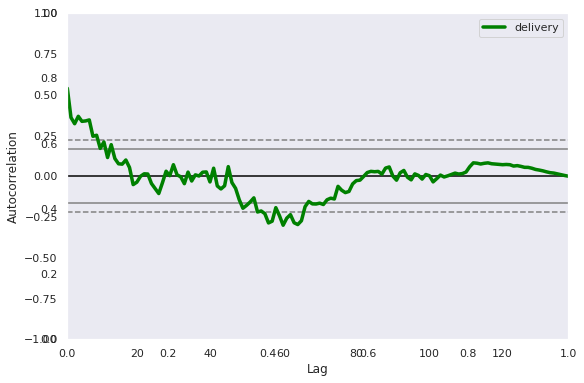

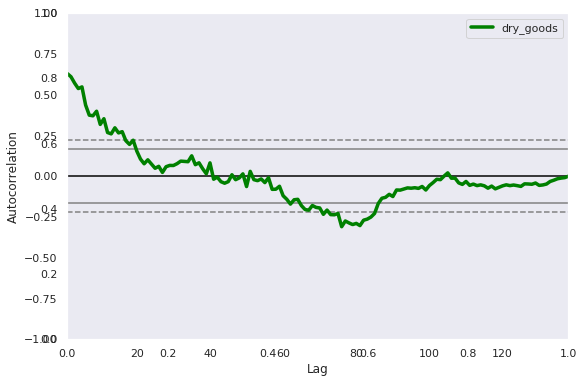

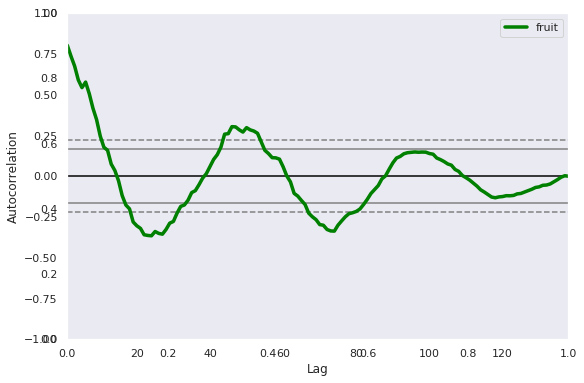

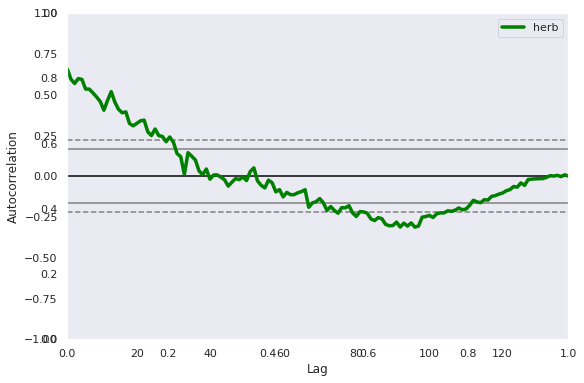

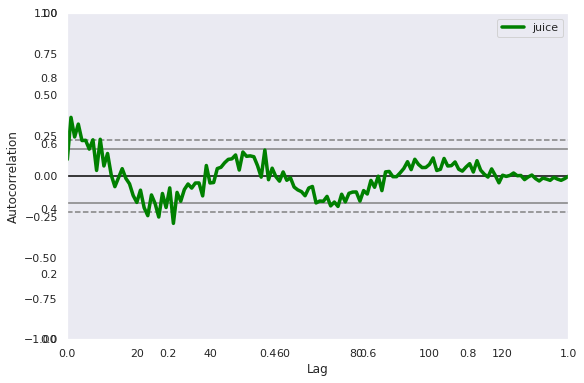

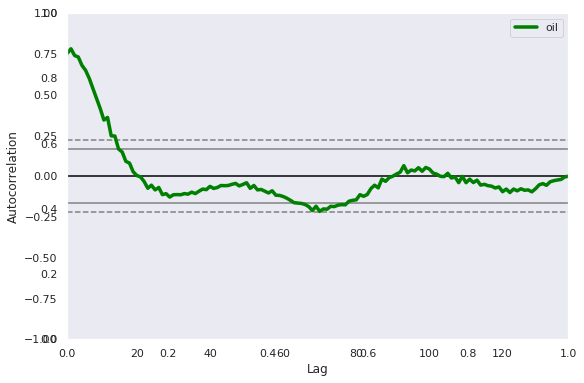

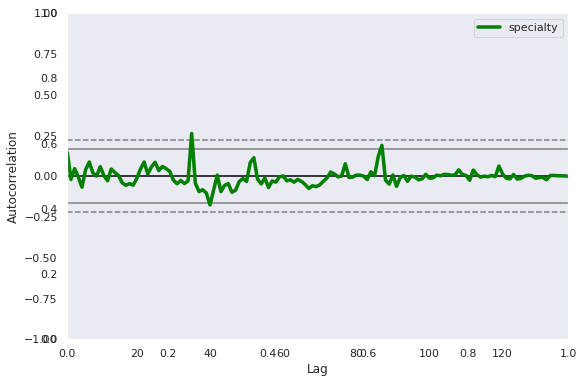

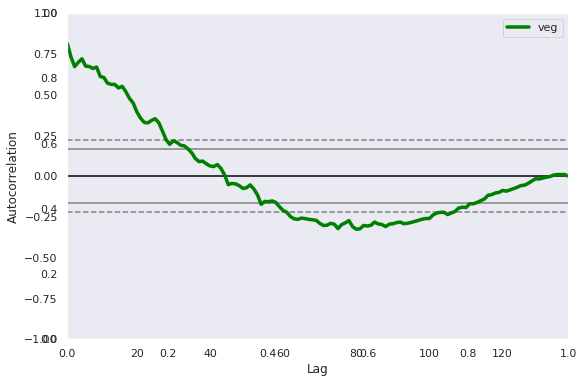

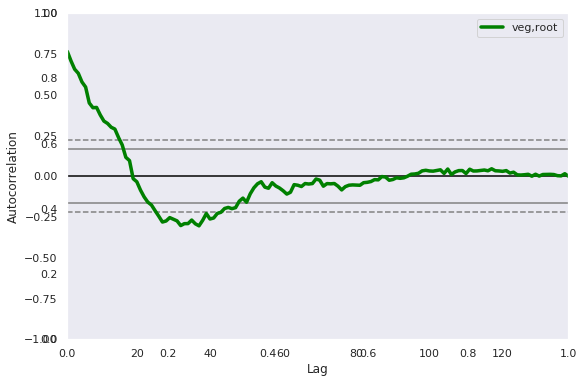

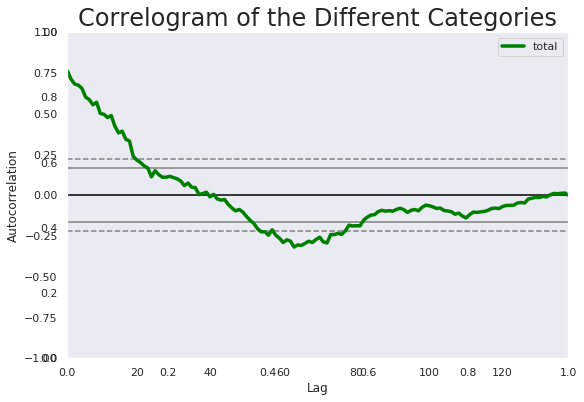

In [0]:
from pandas.plotting import autocorrelation_plot

for col in dfqty.columns:
  plt.subplots(1, figsize=(8,6))
  autocorrelation_plot(dfqty[col], label= col, linewidth=3.5, color='green')
plt.legend()
plt.title("Correlogram of the Different Categories", fontsize= 24)

#### Insights


*   The worst outcome is to see all the data within the 99% & 95% confidence intervals. We saw this with the dairy and the specialty category.
*   Other graphs show a linear decline after a couple dozen lags (veg, delivery, root vegetable, oil, herb). This shows an obvious trend that we will next go through and take out so see if we are left with any signal.
* Finally fruit and juice produced VERY weak autocorrelations, but indicate some seasonality
* Next we will convert the data to stationary so we can see if there's any signal after we take out the trend and signal.



## 3.3 Checking for signal with stationary data

<Figure size 1080x576 with 0 Axes>

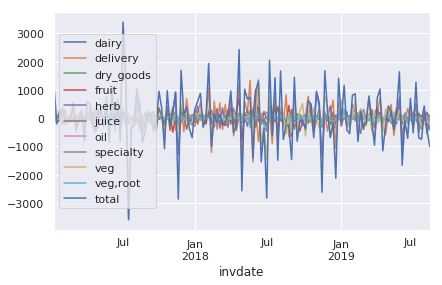

In [0]:
stationary= pd.DataFrame()
diff= pd.DataFrame()

for col in dfqty.columns:
#   stationary[col] = np.log(dfqty[col])
  diff[col] = dfqty[col] - dfqty[col].shift(1) #one period differencing

#So you can visually see the data is transformed into stationary data
plt.figure(figsize= (15,8))
diff.dropna(inplace= True)
diff.head()
diff.plot()

Text(0.5, 1.0, 'Correlogram of Stationary Data')

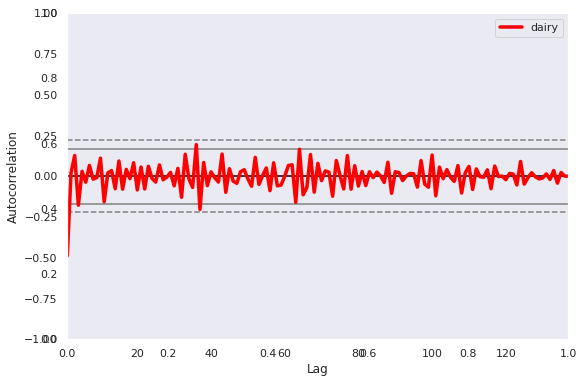

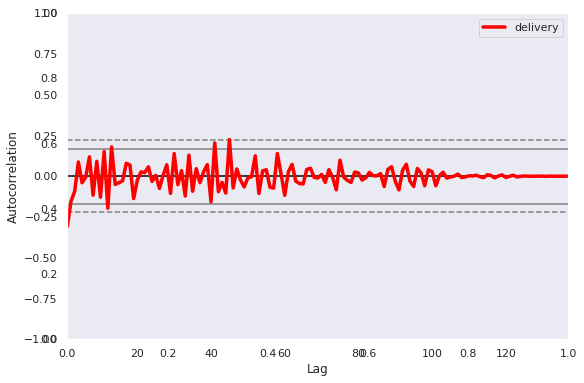

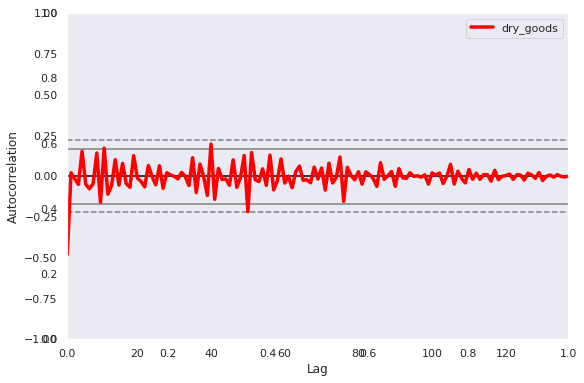

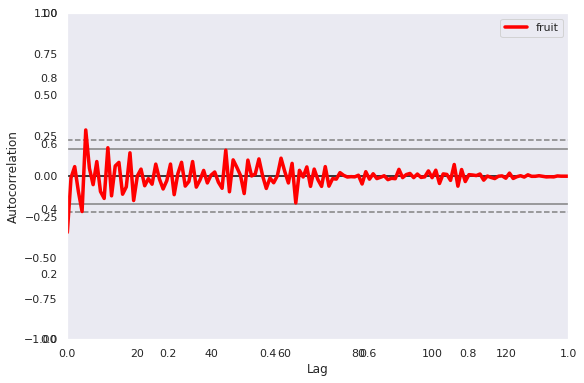

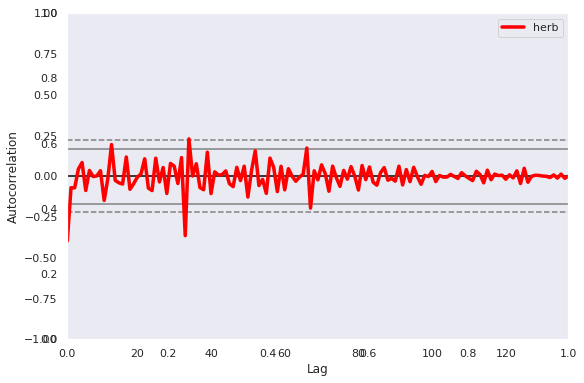

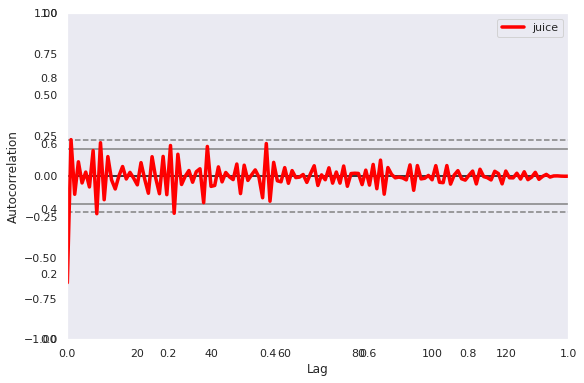

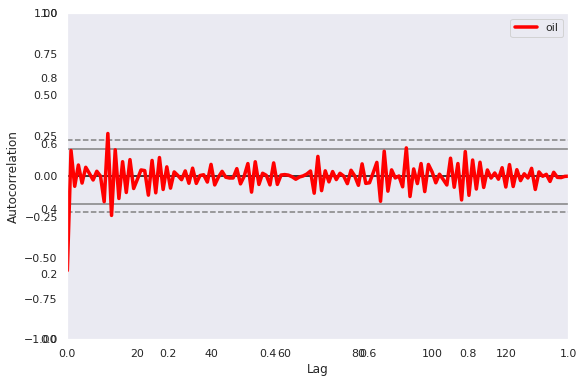

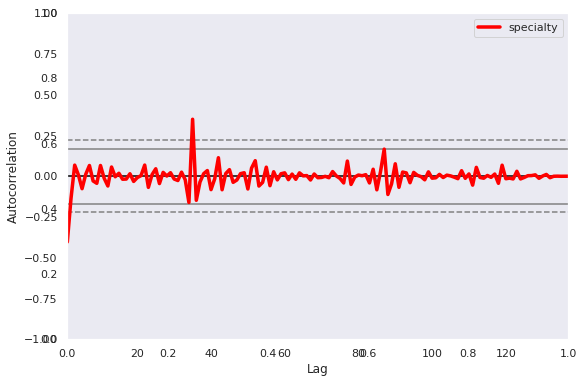

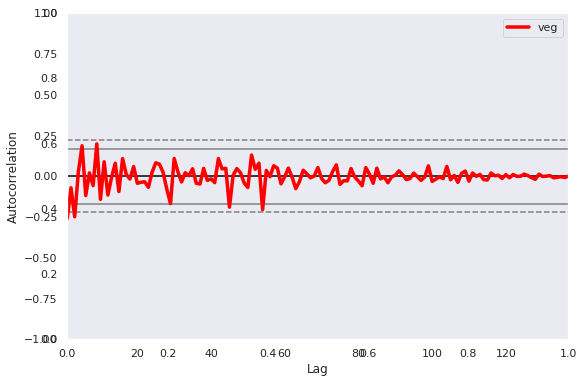

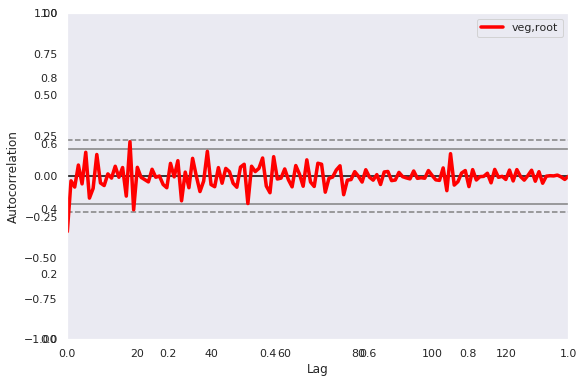

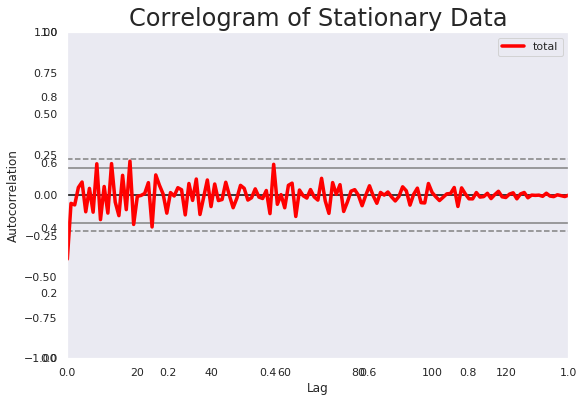

In [0]:
#Now let's check for signal in this converted stationary data
for col in diff.columns:
  plt.subplots(1, figsize=(8,6))
  autocorrelation_plot(diff[col], label= col, linewidth=3.5, color='red')
plt.legend()
plt.title("Correlogram of Stationary Data", fontsize= 24)



#### Insights

* Yikes, this is not good! There are no signicant relationships with any of the categories and their pasts once seasonlity and trend were taken out. 
* All the categories were statistically confident that their relationships with past lags all hovered around 0
* HOWEVER, we shall proceed and see if any models can out perform the naive model (tell-tale sign of a random walk process is that the naive model is the best a prediction can do).


# 4. Splitting into Train/ Test Sets

Before all these delicious predictions can take place, we must first split the data into train and test sets!

>* Since a timeseries forecast is dependent on having the trends of the past, it is not possible to take a random sample of the dataset because it would ruin the historic pattern. Thus, in timeseries forecasting, the standard is to set aside continuous time periods of data, usually the most recent period.
>* I will segment the data from May 1st, 2019 . This is a bit of a gamble because Summer 2019 did not prove to be very in line with the 2018 orders. 



In [0]:
#Splitting data into train/test splits
train= dfqty[:'2019-05-01'] 
test= dfqty['2019-05-01':]
print (f"Percent of Training Data = {test.shape[0]/ train.shape[0]*100:.3f} %")
## The training data represents around 9.5% of the entire time series

Percent of Training Data = 13.115 %


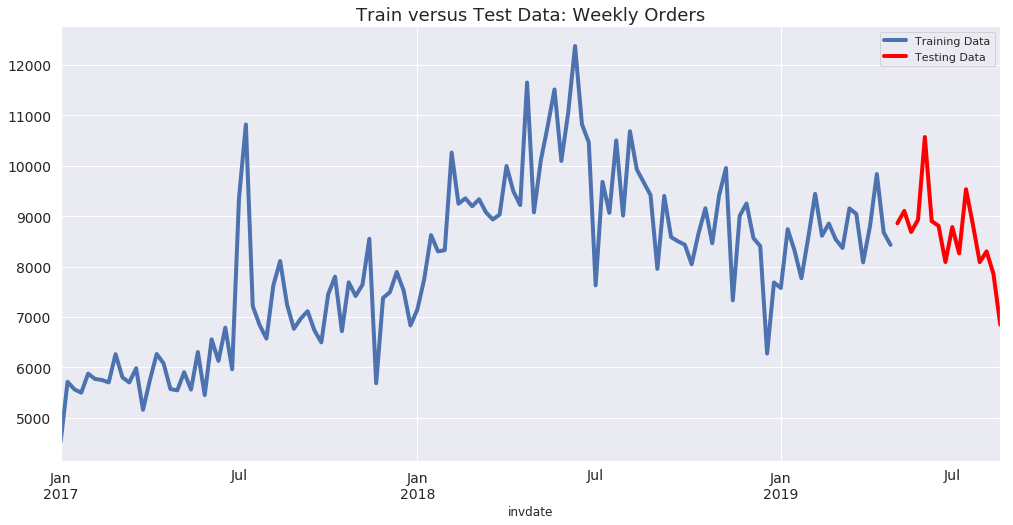

In [0]:
#Graphing the test versus training 
train.total.plot(figsize=(15,8), label= 'Training Data', fontsize=14, linewidth= 4)
test.total.plot(figsize=(15,8), label='Testing Data' , fontsize=14, linewidth= 4, color= 'red')
plt.legend()
plt.title('Train versus Test Data: Weekly Orders', fontsize= 18)
plt.show()

# 5. Naive Forecast- Establishing a Baseline Measure


*   With this model, we will establish a basline measure to measure all of our models against
*   The Naive forecast *literally* only takes the past value and inserts it into the present timeframe. No calculations, just a simple shifting of data from one timeframe to another.
* This is a very important metric for this data in particular because if we cannot beat the outcome of this Naive forecast, then we truly have random walks on our hands.





In [0]:
#literally JUST taking the value from the past timeframe and inserting into the present forecast
predictions= pd.DataFrame()
for col in test.columns:
    predictions[col]= test[col].shift(1)


In [0]:
  #Getting rid of the first NaN row to compute MAE
  df = test.iloc[1:]
  predict= predictions.iloc[1:]

In [0]:
#Computing MAE for each column
from sklearn.metrics import mean_absolute_error
# mean_absolute_error(dfqty[col], predict[col]

print ("---RESULTS OF NAIVE FORECAST PREDICTION PER CATEGORY---\n")
mae_n={}
for col in df.columns:
  mae_nv = mean_absolute_error(df[col], predict[col])
  mae_n[col]= round(mean_absolute_error(df[col], predict[col]))
  print (f"{col} MAE = {mae_nv}")
 


---RESULTS OF NAIVE FORECAST PREDICTION PER CATEGORY---

dairy MAE = 171.21333333333334
delivery MAE = 211.0
dry_goods MAE = 21.14666666666667
fruit MAE = 153.35666666666668
herb MAE = 230.00666666666675
juice MAE = 162.78266666666664
oil MAE = 37.86666666666667
specialty MAE = 81.96666666666667
veg MAE = 185.32266666666638
veg,root MAE = 79.29333333333328
total MAE = 708.0086666666664


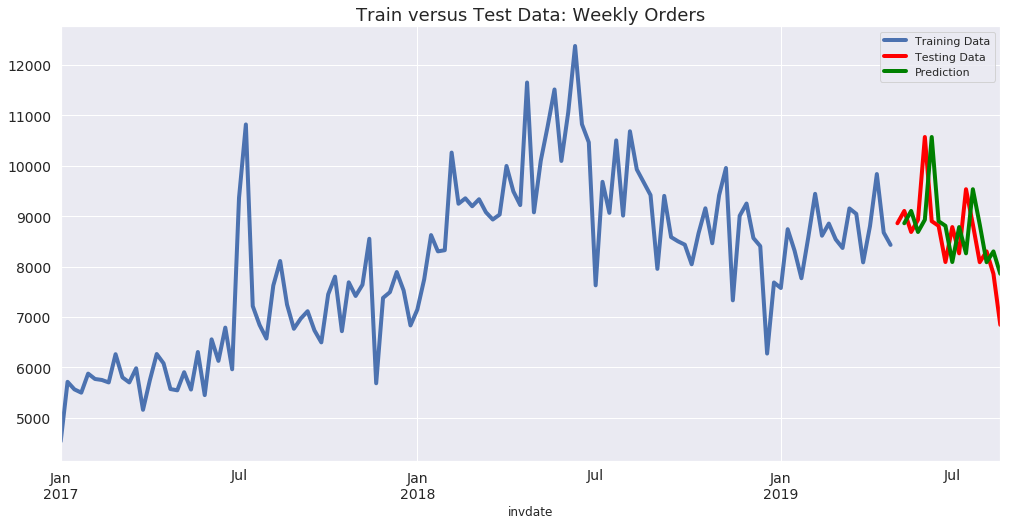

In [0]:
train.total.plot(figsize=(15,8), label= 'Training Data', fontsize=14, linewidth= 4)
test.total.plot(figsize=(15,8), label='Testing Data' , fontsize=14, linewidth= 4, color= 'red')
predictions.total.plot(figsize=(15,8), label='Prediction' , fontsize=14, linewidth= 4, color= 'green')
plt.legend()
plt.title('Train versus Test Data: Weekly Orders', fontsize= 18)
plt.show()

# 6. Simple Moving Average- Another Basic Model

* Averages equally the amount of past periods you specify
* Will use some gridsearch methods to figure out the optimal time period to go backwards
* Then I will calculate each time period per category


In [0]:
#GOING TESTING HOW MANY PERIODS ARE BEST TO GO BACKWARD FOR SIMPLE MOVING AVERAGE. TESTED ALL THREE EVAULTATION METRICS FOR FUN

from sklearn.metrics import mean_squared_error

#MSE

y_hat_avg = test.copy()

print ("TESTING FOR THE BEST NUMBER OF ROLLING PERIODS BASED ON MSE: \n")

#create  a for loop to figure out the best number of periods to go backward
for i in range(20):
  
  y_hat_avg['moving_avg_forecast'] = train['total'].rolling(i).mean().iloc[-1] # i in rolling means we are consider i periods (i weeks) of previous data to make our prediction
  y_hat_avg['moving_avg_forecast'].fillna(0, inplace= True)
  mean_absolute_error(test.total, y_hat_avg.moving_avg_forecast)
  ma_mse =  mean_squared_error(test.total, y_hat_avg.moving_avg_forecast)
  print(f"Number of periods: {i} \n MAE = {ma_mse}")
  
#MAE

y_hat_avg = test.copy()

print ("TESTING FOR THE BEST NUMBER OF ROLLING PERIODS BASED ON MAE: \n")

#create  a for loop to figure out the best number of periods to go backward
for i in range(20):
  
  y_hat_avg['moving_avg_forecast'] = train['total'].rolling(i).mean().iloc[-1] # i in rolling means we are consider i periods (i weeks) of previous data to make our prediction
  y_hat_avg['moving_avg_forecast'].fillna(0, inplace= True)
  mean_absolute_error(test.total, y_hat_avg.moving_avg_forecast)
  ma_mae =  mean_absolute_error(test.total, y_hat_avg.moving_avg_forecast)
  print(f"Number of periods: {i} \n MAE = {ma_mae}")
  

y_hat_avg = test.copy()

print ("TESTING FOR THE BEST NUMBER OF ROLLING PERIODS BASED ON RMSE: \n")

#create  a for loop to figure out the best number of periods to go backward
for i in range(20):
  
  y_hat_avg['moving_avg_forecast'] = train['total'].rolling(i).mean().iloc[-1] # i in rolling means we are consider i periods (i weeks) of previous data to make our prediction
  y_hat_avg['moving_avg_forecast'].fillna(0, inplace= True)
  rms = sqrt(mean_squared_error(test.total, y_hat_avg.moving_avg_forecast))
  print(f"Number of periods: {i} \n RMSE = {rms}")
  
  

TESTING FOR THE BEST NUMBER OF ROLLING PERIODS BASED ON MSE: 

Number of periods: 0 
 MAE = 75469298.49986877
Number of periods: 1 
 MAE = 656968.6019312546
Number of periods: 2 
 MAE = 617311.6934312474
Number of periods: 3 
 MAE = 713654.9229881951
Number of periods: 4 
 MAE = 686669.798199997
Number of periods: 5 
 MAE = 619620.2730227509
Number of periods: 6 
 MAE = 632233.4011986137
Number of periods: 7 
 MAE = 650053.31594936
Number of periods: 8 
 MAE = 628384.3754406251
Number of periods: 9 
 MAE = 620815.9081048605
Number of periods: 10 
 MAE = 622820.2328875004
Number of periods: 11 
 MAE = 619260.7220913746
Number of periods: 12 
 MAE = 634919.1961656241
Number of periods: 13 
 MAE = 629068.7638551401
Number of periods: 14 
 MAE = 612660.3691653061
Number of periods: 15 
 MAE = 609332.0132752503
Number of periods: 16 
 MAE = 609582.6489562499
Number of periods: 17 
 MAE = 607400.4859793899
Number of periods: 18 
 MAE = 611957.8843054028
Number of periods: 19 
 MAE = 643584.6

#### Insights
* I just wanted to see if there was a vast difference between the metrics, but they all had similar results!
* Weeks 2, 16, 17 seem to be good a timeframe to go back to calculate the moving average. 

In [0]:
#training models based on the best roll back periods
y_hat_avg2 = test.copy()
mae_sma2={}
print ("\n---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 2 periods---\n")
for col in train.columns: 
  y_hat_avg2[col] = train[col].rolling(2).mean().iloc[-1] #rolling = 2 means the number of weeks to go backwards
  mae2 = mean_absolute_error(test[col], y_hat_avg2[col])
  mae_sma2[col]=round(mean_absolute_error(test[col], y_hat_avg2[col]))
  print(f"{col} MAE: {mae2}")
  
y_hat_avg16 = test.copy()
mae_sma16={}
print ("\n---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 17 periods---\n")
for col in train.columns: 
  y_hat_avg16[col] = train[col].rolling(16).mean().iloc[-1] #rolling = 2 means the number of weeks to go backwards
  mae16 = mean_absolute_error(test[col], y_hat_avg16[col])
  mae_sma16[col]=round(mean_absolute_error(test[col], y_hat_avg16[col]))
  print(f"{col} MAE: {mae16}")


y_hat_avg17 = test.copy()
mae_sma17={}
print ("\n---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 17 periods---\n")
for col in train.columns: 
  y_hat_avg17[col] = train[col].rolling(17).mean().iloc[-1] #rolling = 2 means the number of weeks to go backwards
  mae17 = mean_absolute_error(test[col], y_hat_avg17[col])
  mae_sma17[col]=round(mean_absolute_error(test[col], y_hat_avg17[col]))
  print(f"{col} MAE: {mae17}")



---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 2 periods---

dairy MAE: 200.0749999999998
delivery MAE: 246.4375
dry_goods MAE: 23.502500000000033
fruit MAE: 149.51749999999967
herb MAE: 260.53562499999964
juice MAE: 122.08500000000001
oil MAE: 23.296875
specialty MAE: 63.15625
veg MAE: 324.0375000000007
veg,root MAE: 87.92062500000006
total MAE: 584.5218749999967

---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 17 periods---

dairy MAE: 140.1890625
delivery MAE: 363.17031250000014
dry_goods MAE: 14.098671875000022
fruit MAE: 384.1193749999999
herb MAE: 238.20273437499986
juice MAE: 153.935859375
oil MAE: 45.745078125000006
specialty MAE: 51.598984375
veg MAE: 310.2096874999995
veg,root MAE: 94.44390625000001
total MAE: 548.9835937499997

---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 17 periods---

dairy MAE: 142.7639705882353
delivery MAE: 346.7080882352942
dry_goods MAE: 13.547500000000008
fruit MAE: 398.0786029411762
herb MAE: 231.015404411764

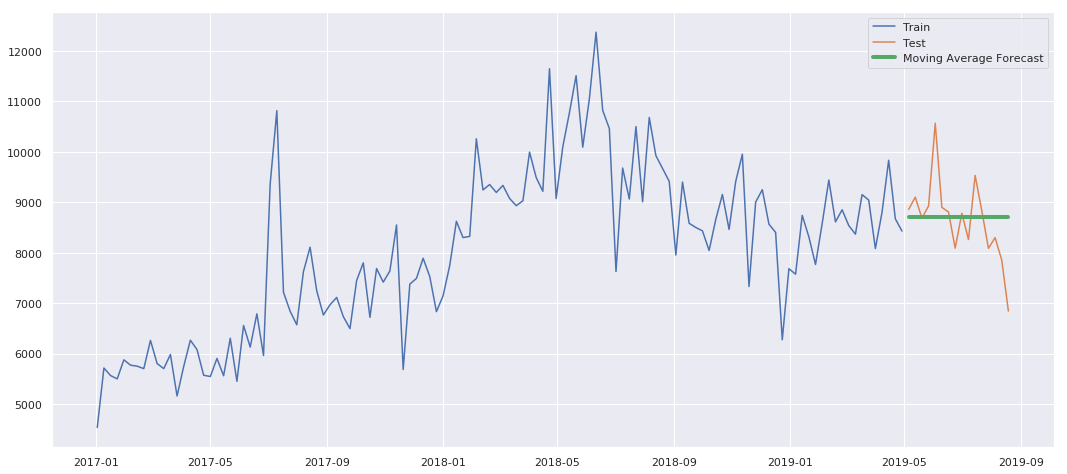

In [0]:
#graph the results
plt.figure(figsize=(16,8))
plt.plot(train['total'], label='Train')
plt.plot(test['total'], label='Test')
plt.plot(y_hat_avg16['total'], label='Moving Average Forecast', linewidth= 4)
plt.legend(loc='best')
plt.show()

#### Insights
* I was curious which time period did better... Going back two weeks or going back 4 months
* Each category had a different result so it is very much dependent on the type of product of how many time periods to go backward. This will be the case with all the models. With so many different timeseries distributions it's only natural that they need to be customized per SKU
* The Simple moving average model was able to outperform the Naive forecast in all categories except root vegetable and herb. This is good news that a model that's one step above the Naive forecast was able to outperform it. Hoping this will be the case with the more complicated models!
* *Notice something? The predictions are flat! Moving averages by definition are not going to be able to predict trend because when you take the average of past time periods you will always smooth out whatever trend you see.*
 

# 7. Other Models for Kicks

7.1 Simple Exponential Smoothing
>* Gives higher weights to recent data, and lower weights to older data and then takes the average of the values with the weights taken into account.

7.2 Holts Linear Model
>* Holts Linear Trend will do the same as the exponential smoothing, but also take into account the trend of the data

7.3 Holts Winter Model
>* Holts Winter Method does triple exponential smoothing to try to uncover seasonality and trend.
>* You must calculate the correct seasonality

## 7.1 Exponential Smoothing

In [0]:
#calculating the best alpha

y_hat_ses = test.copy()

for num in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
  
  fit2 = SimpleExpSmoothing(np.asarray(train['total'])).fit(smoothing_level=num,optimized=False)
  y_hat_ses['SES'] = fit2.forecast(len(test))

  #Calculating result
  maes = mean_absolute_error(test.total, y_hat_ses.SES)
  print(f"Alpha: {num} \n MAE = {maes}")

Alpha: 0.1 
 MAE = 549.5667970830127
Alpha: 0.2 
 MAE = 542.4365356462586
Alpha: 0.3 
 MAE = 540.8955068397154
Alpha: 0.4 
 MAE = 544.2108478589089
Alpha: 0.5 
 MAE = 549.9534263786741
Alpha: 0.6 
 MAE = 563.0640412349703
Alpha: 0.7 
 MAE = 578.5168742615324
Alpha: 0.8 
 MAE = 593.548162525351
Alpha: 0.9 
 MAE = 606.3602141161086


####Insights
* .01 alpha gives the best results


---RESULTS OF SIMPLE EXPONENTIAL SMOOTHING PREDICTION PER CATEGORY---



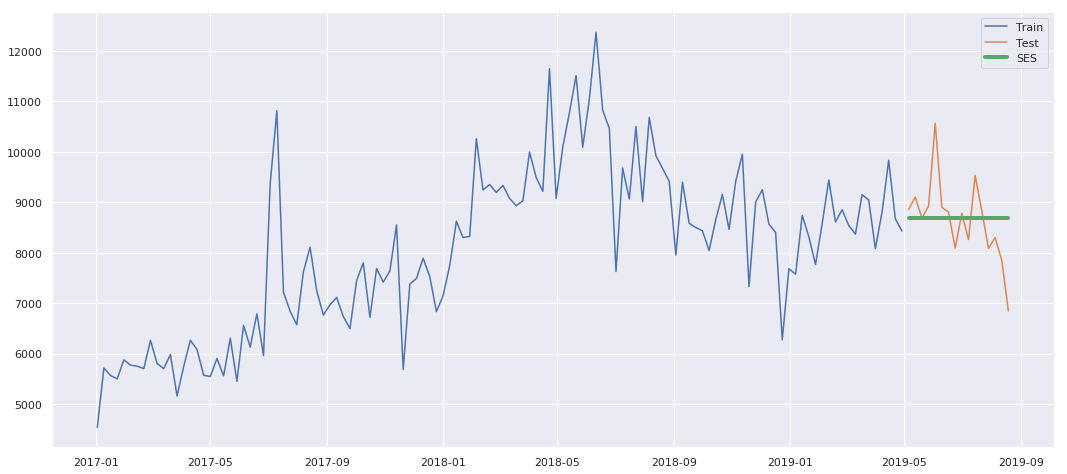

In [0]:
#Imports
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

print ("\n---RESULTS OF SIMPLE EXPONENTIAL SMOOTHING PREDICTION PER CATEGORY---\n")
mae_ses= {}
#Model
for col in train.columns:
  fit2 = SimpleExpSmoothing(np.asarray(train[col])).fit(smoothing_level=0.1,optimized=False) #fit with the optimal alpha .1
  y_hat_ses[col] = fit2.forecast(len(test))
  #Calculating result
  mae_ses[col]=round(mean_absolute_error(test[col], y_hat_ses[col]))


#plot
plt.figure(figsize=(16,8))
plt.plot(train['total'], label='Train')
plt.plot(test['total'], label='Test')
plt.plot(y_hat_ses['total'], label='SES', linewidth= 4)
plt.legend(loc='best')
plt.show()

## 7.2 Holt’s Linear Trend method 


In [0]:
#TESTING DIFFERENT PARAMETERS: Holt’s Linear Trend method

for num in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
  for i in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
  
    fit1 = Holt(np.asarray(train['total'])).fit(smoothing_level = num,smoothing_slope = i)
    y_hat_avg['Holt_linear'] = fit1.forecast(len(test))
    mae_ht = mean_absolute_error(test.total, y_hat_avg.Holt_linear)
    
    #Calculating result
    print(f"Smoothing level= {num} \n Smoothing slope = {i} \n MAE: {mae_ht}")

Smoothing level= 0.1 
 Smoothing slope = 0.1 
 MAE: 647.6139110839608
Smoothing level= 0.1 
 Smoothing slope = 0.2 
 MAE: 1201.9743405740994
Smoothing level= 0.1 
 Smoothing slope = 0.3 
 MAE: 1162.028556542548
Smoothing level= 0.1 
 Smoothing slope = 0.4 
 MAE: 1041.474611525258
Smoothing level= 0.1 
 Smoothing slope = 0.5 
 MAE: 1173.6224080087975
Smoothing level= 0.1 
 Smoothing slope = 0.6 
 MAE: 1304.7127968638038
Smoothing level= 0.1 
 Smoothing slope = 0.7 
 MAE: 1360.1879001330558
Smoothing level= 0.1 
 Smoothing slope = 0.8 
 MAE: 987.9666471883166
Smoothing level= 0.1 
 Smoothing slope = 0.9 
 MAE: 498.2442696802565
Smoothing level= 0.2 
 Smoothing slope = 0.1 
 MAE: 699.5505357811783
Smoothing level= 0.2 
 Smoothing slope = 0.2 
 MAE: 891.8269731351759
Smoothing level= 0.2 
 Smoothing slope = 0.3 
 MAE: 817.108412674253
Smoothing level= 0.2 
 Smoothing slope = 0.4 
 MAE: 579.6836850955385
Smoothing level= 0.2 
 Smoothing slope = 0.5 
 MAE: 457.9745416323703
Smoothing level= 

#### Insights
* Optimal Smoothing level= 0.4 
* Optimal Smoothing slope = 0.7

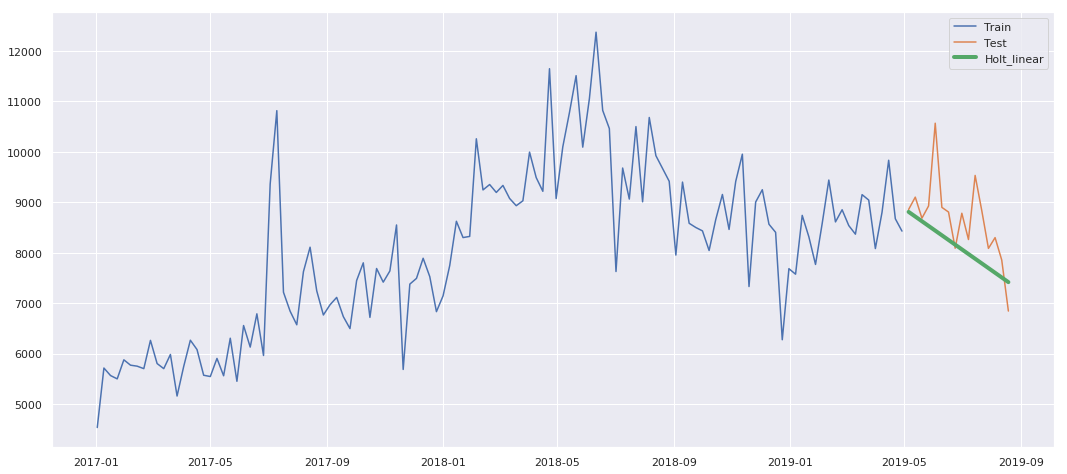

In [0]:
#implementing the mode with the optimal parameters
y_hat_hlt = test.copy()
mae_hlt= {}

for col in train.columns:
  fit1 = Holt(np.asarray(train[col])).fit(smoothing_level = 0.4,smoothing_slope = 0.7)
  y_hat_hlt[col] = fit1.forecast(len(test))
  mae_hlt[col]=round(mean_absolute_error(test[col], y_hat_hlt[col]))

plt.figure(figsize=(16,8))
plt.plot(train['total'], label='Train')
plt.plot(test['total'], label='Test')
plt.plot(y_hat_hlt['total'], label='Holt_linear', linewidth= 4)
plt.legend(loc='best')
plt.show()

## 7.3 Holt’s Winter Method 

* This method is suposed to capture the seasonality 

In [0]:
#figuring out the optimal number of seasonal periods
y_hat_avg = test.copy()

for num in range(2, 30):
  
  fit1 = ExponentialSmoothing(np.asarray(train['total']) ,seasonal_periods=num ,trend='add', seasonal='add',).fit()
  y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

  mae_h = mean_squared_error(test.total, y_hat_avg.Holt_Winter)

  #Calculating result
  print(f"Number of Seasonal Periods: {num} \n MAE = {mae_h}")

Number of Seasonal Periods: 2 
 MAE = 942098.079150418
Number of Seasonal Periods: 3 
 MAE = 992437.2590096002
Number of Seasonal Periods: 4 
 MAE = 822606.2948062181
Number of Seasonal Periods: 5 
 MAE = 959874.0306387835
Number of Seasonal Periods: 6 
 MAE = 1199589.015905581
Number of Seasonal Periods: 7 
 MAE = 910158.9562172599
Number of Seasonal Periods: 8 
 MAE = 859572.8377345167
Number of Seasonal Periods: 9 
 MAE = 1065003.202972055
Number of Seasonal Periods: 10 
 MAE = 1065795.096197302
Number of Seasonal Periods: 11 
 MAE = 882861.8898003303
Number of Seasonal Periods: 12 
 MAE = 1152649.2945794954
Number of Seasonal Periods: 13 
 MAE = 1091703.7867995247
Number of Seasonal Periods: 14 
 MAE = 1123278.8887589655
Number of Seasonal Periods: 15 
 MAE = 946502.4770506679
Number of Seasonal Periods: 16 
 MAE = 1082061.1612757863
Number of Seasonal Periods: 17 
 MAE = 1226985.6227340356
Number of Seasonal Periods: 18 
 MAE = 1347709.3225124287
Number of Seasonal Periods: 19 
 M

#### Insights
* Optimal seasons seems to be 19

{'dairy': 7959.0, 'delivery': 8386.0, 'dry_goods': 8721.0, 'fruit': 7396.0, 'herb': 6873.0, 'juice': 8386.0, 'oil': 8708.0, 'specialty': 8748.0, 'veg': 6356.0, 'veg,root': 8063.0, 'total': 624.0}


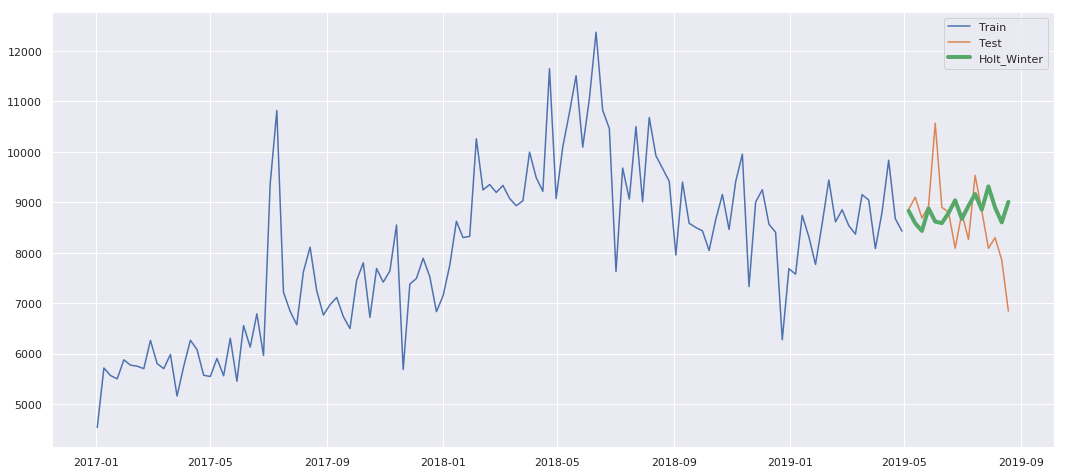

In [0]:
#Testing model with optimal parameters

y_hat_hwm = test.copy()
mae_hwm={}
for col in train.columns:
  fit1 = ExponentialSmoothing(np.asarray(train['total']) ,seasonal_periods=19 ,trend='add', seasonal='add',).fit()
  y_hat_hwm[col] = fit1.forecast(len(test))
  mae_hwm[col]= round(mean_absolute_error(test[col], y_hat_hwm[col]))

print (mae_hwm)
  

plt.figure(figsize=(16,8))
plt.plot( train['total'], label='Train')
plt.plot(test['total'], label='Test')
plt.plot(y_hat_hwm['total'], label='Holt_Winter', linewidth= 4)
plt.legend(loc='best')
plt.show()

In [0]:
#FINAL EVALUTATION OF ALL THE MODELS--- Getting an Intuition for which works best

print ("\nRESULTS OF ALL MODELS PER CATEGORY\n")

print ("\n---RESULTS OF NAIVE FORECAST PREDICTION PER CATEGORY---\n")
print (mae_n)

print ("\n---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 2 periods---\n")
print(mae_sma2)

print ("\n---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 16 periods---\n")
print(mae_sma16)

print ("\n---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 17 periods---\n")
print(mae_sma17)

print ("\n---RESULTS OF SIMPLE EXPONENTIAL SMOOTHING PREDICTION PER CATEGORY---\n")
print(mae_ses)
  
print ("\n---RESULTS OF HOLT LINEAR TREND PREDICTION PER CATEGORY---\n")
print(mae_hlt)
  
print ("\n---RESULTS OF HOLT WINTER METHOD PER CATEGORY---\n")
print(mae_hwm)
  


RESULTS OF ALL MODELS PER CATEGORY


---RESULTS OF NAIVE FORECAST PREDICTION PER CATEGORY---

{'dairy': 171.0, 'delivery': 211.0, 'dry_goods': 21.0, 'fruit': 153.0, 'herb': 230.0, 'juice': 163.0, 'oil': 38.0, 'specialty': 82.0, 'veg': 185.0, 'veg,root': 79.0, 'total': 708.0}

---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 2 periods---

{'dairy': 200.0, 'delivery': 246.0, 'dry_goods': 24.0, 'fruit': 150.0, 'herb': 261.0, 'juice': 122.0, 'oil': 23.0, 'specialty': 63.0, 'veg': 324.0, 'veg,root': 88.0, 'total': 585.0}

---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 16 periods---

{'dairy': 140.0, 'delivery': 363.0, 'dry_goods': 14.0, 'fruit': 384.0, 'herb': 238.0, 'juice': 154.0, 'oil': 46.0, 'specialty': 52.0, 'veg': 310.0, 'veg,root': 94.0, 'total': 549.0}

---RESULTS OF SIMPLE MOVING AVERAGE PREDICTION PER CATEGORY 17 periods---

{'dairy': 143.0, 'delivery': 347.0, 'dry_goods': 14.0, 'fruit': 398.0, 'herb': 231.0, 'juice': 156.0, 'oil': 47.0, 'specialty': 52.0

### 7.1.2.3 Overall Insights
* vegetable, root vegetable, delivery and herbs did NOT benefit from more complicated models. This is not good news for the random walk results
* Otherwise, all the other categories did benefit from from either simple exponential smoothing or simple moving average. None of the models benefitted from the Holts methods trying to capture seasonality or trend. This may indicate that perhaps the most simple model is best for this data
* The Holt's Winter Method did awful. It didn't capture the seasonality at all. This is a good insight to go in with. Perhaps accounting for seasonality is not the best.


# 8. Basic Model Insights


*   The first three indicators (non-stationary data and the correlograms) indicate the data is definitely random walk processes. 
* The last, improvement of other models to the Naive forecast, suprisingly had favorable outcomes, but only slightly, but this was most likely because the other slightly more complicated models helped adjust for the trend and seasonality, whereas the naive model was fed the non-stationary data.
* Next Steps: TEST Everything! What will happen if I change the history of the forecast (1 year, 2 year, 1.5 years), or change the forecast interval (daily, weekly, bimonthly, monthly), or difference/ take the log of this data with all of these combinations. See what is the best scope for this time-series forecast.

